### Get organization and identify party
Our goal is to identify which organization, first party, support party, or third party, own the domains. 


### Input file:
input_dir = "/home/hutr/iot-longitudinal/output_destination/{device_comparison_set}/{year}{exp}/domain_list"
device_comparison_set = ['common_devices', 'all_devices_remove_duplicates']
year = ['2019', '2021', '2022', '2023', '2024']
exp = ['idle', 'activity', 'power']

- DNS/TLS extracted domains: f"{input_dir}/unique_domains.json"
- DNS/TLS extracted SLDs: f"{input_dir}/unique_slds.json"
- Contacted IP translated domains: f"{input_dir}/contacted_domains_with_all_dns.json"
- Contacted slds: f"{input_dir}/contacted_slds_with_all_dns.json"


In [20]:
'domains by proxy' in 'domains by proxy, llc'

True

In [9]:
import whois
# from ipwhois import IPWhois
import whoisdomain
import ipaddress
import pandas as pd
import numpy as np
import os 
import csv
import json
import time
import subprocess
import tldextract

def get_sld(domain):
    ext = tldextract.extract(domain)
    return f"{ext.domain}.{ext.suffix}"

def is_local_address(ip_str):
    LOCAL_IPS = ['129.10.227.248', '129.10.227.207']
    try:
        if ip_str == "::" or ip_str == "::1":
            return True
        if is_ipv6(ip_str):
            ip = ipaddress.IPv6Address(ip_str)
            return ip.is_multicast or ip.is_link_local or (
                ip.is_private and check_in_network("fc00::/7", ip)
                ) or ip.is_unspecified
        else:
            ip = ipaddress.ip_address(ip_str)
            return ip.is_private or ip.is_multicast or ip == ipaddress.IPv4Address("255.255.255.255") or ip_str in LOCAL_IPS
    except:
        return False

def check_in_network(network_prefix, ip):
    if ip is None or network_prefix is None:
        return False
    network = ipaddress.IPv6Network(network_prefix, strict=False)
    return ip in network

def is_ipv6(address:str) -> bool:
    try:
        ip = ipaddress.ip_address(address)
        if isinstance(ip, ipaddress.IPv6Address):
            # print("{} is an IPv6 address".format(address))
            return True
        else:
            return False
    except ValueError:
        return False
    
def is_valid_ip(i):
    try:
        ipaddress.ip_address(i)
        return True
    except ValueError:
        return False

def get_whois_data(domain):
    try:
        result = subprocess.run(['whois', domain], stdout=subprocess.PIPE)
        return result.stdout.decode()
    except:
        return None

def privacy_protected_org_name(org:str):
    org = org.lower()
    if 'data protected' in org or 'domains by proxy' in org or \
            'redacted' in org or 'not disclosed' in org or \
            'protection' in org or 'privacy' in org:
        return True
    return False
    

def get_organization_command_line(domain):
    whois_data = get_whois_data(domain)
    if whois_data:
        org_list = []
        for line in whois_data.split("\n"):
            if 'Organization' in line.strip() or 'OrgName' in line.strip():
                try:
                    org = line.split(":")[1].strip()
                except:
                    continue
                if privacy_protected_org_name(org):
                    continue
                if len(org) > 0:
                    org_list.append(org)
        # print(domain, org_list)
        if len(org_list) > 0:
            return org_list
        else:
            return None

    return None


def get_organization_whois(domain):
    try:
        w = whois.whois(domain)
        # if domain == 'a2z.com':
        
        if w and 'org' in w:
            # print(domain, w['org'])
            organization = w['org']
            if isinstance(organization, str):
                # print(domain, organization, privacy_protected_org_name(organization))
                if privacy_protected_org_name(organization):
                    return None
                return [organization]
            elif isinstance(organization, list):
                new_org_list = []
                for org in organization:
                    if privacy_protected_org_name(org):
                        continue
                    if len(org) > 0:
                        new_org_list.append(org)
                if len(new_org_list) > 0:
                    return new_org_list
                else:
                    return None

        return None
    except:
        return None

def get_organization_whoisdomain(domain):
    try:
        w = whoisdomain.query(domain).__dict__
    except:
        return None
    if w and 'registrant' in w:
        # print(domain, w['registrant'])
        organization = w['registrant']
        # print(organization)
        if isinstance(organization, str):
            return [organization]
        elif isinstance(organization, list):
            if privacy_protected_org_name(organization):
                return None
            return organization

    return None



def read_input(file):
    data = pd.read_csv(file)
    hosts = np.array(data['hosts'].fillna('').values)
    return hosts


def read_first_party(file):
    device_first_party = {}
    
    with open(file, 'r') as f:
        lines = f.readlines()
        for line in lines:
            if line:
                device = line.split()[0]
                first_party = line.split()[1:]
                device_first_party[device] = first_party
    return device_first_party


def process_single(input_string, device_first_party, domain_org_dict):
    save_org = None

    # Check if the input is a valid IP address and not a local address
    if is_valid_ip(input_string) and not is_local_address(input_string):
        # IP address to organization
        if input_string in domain_org_dict:
            organization = [domain_org_dict[input_string]]
        else:
            organization = get_organization_command_line(input_string)
            save_org = 1
    else:
        # Process domain name
        input_string = input_string.lower()
        if input_string in domain_org_dict:
            organization = [domain_org_dict[input_string]]
        else:
            organization = get_organization_command_line(input_string)
            save_org = 1

    # Handle organization data
    if organization:
        if save_org == 1:
            save_org = organization[0]
            if save_org == 'Charleston Road Registry, Inc.':
                save_org = 'Google Registry'
            print(input_string, organization)
        organization.append(input_string)
    else:
        # Default organization handling for specific domains
        if input_string in ['amcs-tachyon.com', 'a2z.com', 'fireoscaptiveportal.com']:
            organization = ['Amazon Technologies, Inc.']
        else:
            organization = [input_string]

    # Determine the party type
    party = 0
    support_party_list = ['aws', 'cloudflare', 'amazon', 'org', 'neu.edu', 'aka', 'digicert', 'Wikimedia', 'cdn', 'akamai', 'cloudfront', 'fastly', 'dns', 'Electric Imp']
    
    if not isinstance(organization, list):
        print('error:', organization, input_string)
    
    # Check if the organization is a first party
    for first_party in device_first_party:
        first_party = first_party.strip().lower()
        for org in organization:
            if first_party in org.lower():
                party = 1
                organization = org
                break
        if party == 1:
            break
    
    # Check if the organization is a support party
    if party != 1:
        for org in organization:
            for s in support_party_list:
                if s in org.lower():
                    party = 2
                    organization = org
                    break
            if party == 2:
                break
    
    # Default to third party if no match found
    if party == 0:
        party = 3
        organization = organization[0]

    return organization, party, save_org

first_party_list = 'first_party_list.txt'


In [10]:
def run_get_org_single_exp(device_domain_dict, output_file):
    if os.path.isfile('domain_org_dict.json'):
        domain_org_dict = json.load(open('domain_org_dict.json','r'))
    else:
        domain_org_dict = {}
    device_first_party = read_first_party(first_party_list)
    for device in device_domain_dict:
        if device not in device_first_party:
            print('Error:', device)

    tmp_output = []
    for device_name in device_domain_dict:
        if device_name not in device_first_party:
            continue
        #     continue
        
        # print(device_name, device_first_party[device_name])
        for domain in device_domain_dict[device_name]:
            # sld:
            # domain = get_sld(domain)
            
            # * get domain org
            organization, party, save_org = process_single(domain, device_first_party[device_name], domain_org_dict)
            tmp_output.append([ device_name, domain, organization, party])
            if save_org and save_org != 1:
                tmp_domain = domain
                if tmp_domain not in domain_org_dict:
                    domain_org_dict[tmp_domain] = save_org

    json.dump(domain_org_dict, open('domain_org_dict.json', 'w'), indent=4)

    print('Saving to:', output_file)
    header = ['device', 'domain', 'org', 'party']
    with open(output_file, 'w') as file:
        writer = csv.writer(file)
        writer.writerow(header)
        writer.writerows(tmp_output)
                


input_dir = "/home/hutr/iot-longitudinal/output_destination/{device_comparison_set}/{year}{exp}/domain_list"
device_comparison_set = ['common_devices', 'all_devices_remove_duplicates']
years = ['2019', '2021', '2022', '2023', '2024']
# exps = ['idle', 'activity', 'power']
# years = ['2021', '2022', '2023', '2024']
years = ['2019']
exps = ['idle', 'activity', 'power']
for year in years:
    for exp in exps:
        cur_input_dir = input_dir.format(device_comparison_set=device_comparison_set[0], year=year, exp=exp)
        file = f"{cur_input_dir}/contacted_slds_with_all_dns.json"
        
        # device domain dictionary: key: device name, value: list of domains
        with open(file, 'r') as f:
            device_domain_dict = json.load(f)
            
        # Remove keys with empty values
        device_domain_dict = {k: v for k, v in device_domain_dict.items() if v} 

        out_dir = os.path.join(os.path.dirname(cur_input_dir), 'domain_org')
        output_file =  os.path.join(out_dir, f'{os.path.basename(file).split('.')[0]}_org.csv')
        if not os.path.exists(out_dir):
            os.system('mkdir -pv %s' % out_dir)
        run_get_org_single_exp(device_domain_dict, output_file)





Saving to: /home/hutr/iot-longitudinal/output_destination/common_devices/2019idle/domain_org/contacted_slds_with_all_dns_org.csv
Saving to: /home/hutr/iot-longitudinal/output_destination/common_devices/2019activity/domain_org/contacted_slds_with_all_dns_org.csv


Timeout.
connect: Network is unreachable


Saving to: /home/hutr/iot-longitudinal/output_destination/common_devices/2019power/domain_org/contacted_slds_with_all_dns_org.csv


### Result analysis:


In [8]:
import pandas as pd
import os
from collections import defaultdict
def convert_to_per_category(df, columns, category_index=2):
    df_per_category = df.copy().iloc[:,1:] # remove device column
    # df_per_category = df.copy()
    # group rows and remove duplicates
    for column in columns[category_index:]:
        df_per_category[column] = df_per_category.groupby('Category')[column].transform('sum')
    df_per_category['Count'] = df_per_category.groupby('Category')['Category'].transform('size')
    # Move 'Count' column to the second position
    cols = df_per_category.columns.tolist()
    cols.insert(1, cols.pop(cols.index('Count')))
    df_per_category = df_per_category[cols]
    
    df_per_category = df_per_category.drop_duplicates(subset=['Category', 'Count'])
    return df_per_category

def add_total_row(df, index=2):
    df_toal = df.copy()
    df_toal.loc['Total'] = df_toal.sum(numeric_only=True, axis=0) # .round().astype(int)
    for i in range(index):
        df_toal.iloc[-1, i] = 'Total'
    for column in df.columns[index:]:
        df_toal[column] = df_toal[column].astype(int)
    return df_toal

def get_device_category_dict():
    category_file = '/home/hutr/iot-longitudinal/input_device_list/device_information.csv'
    device_category = pd.read_csv(category_file)
    device_category_dict = {}
    for index, row in device_category.iterrows():
        device_category_dict[row['NAME']] = row['CATEGORY']
    return device_category_dict

def remove_duplicates_mac_device_dict(data):
    if 'appletv-wifi' in data:
        data['appletv'] = data['appletv-wifi']
        del data['appletv-wifi']
    elif 'samsungtv65-wifi' in data:
        data['samsungtv65-wired'] = data['samsungtv65-wifi']
        del data['samsungtv65-wifi']
    elif 'sengled-hub-spoofed' in data:
        data['sengled-hub'] = data['sengled-hub-spoofed']
        del data['sengled-hub-spoofed']
    elif 'samsungtv-wifi' in data:
        data['samsungtv-wired'] = data['samsungtv-wifi']
        del data['samsungtv-wifi']
    elif 'eufy-hub-wifi' in data:
        data['eufy-hub'] = data['eufy-hub-wifi']
        del data['eufy-hub-wifi']
    return data

def remove_duplicates_mac_device_csv(data):
    # replace all rows with device name 'appletv-wifi' with 'appletv'
    data.loc[data['device'] == 'appletv-wifi', 'device'] = 'appletv'
    data.loc[data['device'] == 'samsungtv65-wifi', 'device'] = 'samsungtv65-wired'
    data.loc[data['device'] == 'sengled-hub-spoofed', 'device'] = 'sengled-hub'
    data.loc[data['device'] == 'samsungtv-wifi', 'device'] = 'samsungtv-wired'
    data.loc[data['device'] == 'eufy-hub-wifi', 'device'] = 'eufy-hub'
    return data

def output_per_category(cur_input_dir, input_file, domain_party_dict):
    output_dict = {}
    for device in domain_party_dict:
        category = device_category_dict[device]
        output_dict[device] = {'Category': category, 'Domain Count': 0, 'First Party': 0, 'Third Party': 0, 'Support Party': 0}
        for domain in domain_party_dict[device]:
            party = domain_party_dict[device][domain]
            output_dict[device]['Domain Count'] += 1
            if party == 1:
                output_dict[device]['First Party'] += 1
            elif party == 2:
                output_dict[device]['Support Party'] += 1
            else:
                output_dict[device]['Third Party'] += 1
        # output for each year-exp 
    column = ['Device', 'Category', 'Domain Count', 'First Party', 'Third Party', 'Support Party']
    df = pd.DataFrame.from_dict(output_dict, orient='index') # 
    df = df.reset_index()
    df_per_category = convert_to_per_category(df, column)
    df_per_category = add_total_row(df_per_category, index=1)
    df_per_category.to_csv(os.path.join(cur_input_dir, f'{input_file.split(".")[0]}_per_category.csv'), index=False)
def output_aggregated(cur_out_dir, out_file, data_cur_year):
    # output data_cur_year to csv. Remove duplicates
    data_cur_year = data_cur_year.drop_duplicates(subset=['device', 'domain'])
    # rank by device
    data_cur_year = data_cur_year.sort_values(by=['device'])
    data_cur_year.to_csv(os.path.join(cur_out_dir, out_file), index=False)
    

input_dir = "/home/hutr/iot-longitudinal/output_destination/{device_comparison_set}/{year}{exp}/domain_org/"
device_comparison_set = ['common_devices', 'all_devices_remove_duplicates']
years = ['2019', '2021', '2022', '2023', '2024']
# exps = ['idle', 'activity', 'power']
exps = ['idle', 'activity', 'power']
input_list = ['contacted_slds_with_all_dns_org.csv',]
out_dir = '/home/hutr/iot-longitudinal/output_destination/{device_comparison_set}/_domain_org_summary'

for year in years:
    domain_party_dict_cur_year = defaultdict(dict)
    data_cur_year = pd.DataFrame()
    for exp in exps:
        cur_input_dir = input_dir.format(device_comparison_set=device_comparison_set[0], year=year, exp=exp)
        cur_out_dir = out_dir.format(device_comparison_set=device_comparison_set[0])

        if not os.path.exists(cur_out_dir):
            os.system('mkdir -pv %s' % cur_out_dir)

        input_file = input_list[0]
        
        device_category_dict = get_device_category_dict()
        
        data = pd.read_csv(os.path.join(cur_input_dir, input_file))
        data = remove_duplicates_mac_device_csv(data)
        data_cur_year = pd.concat([data_cur_year, data])
        
        domain_party_dict = defaultdict(dict)
        for index, row in data.iterrows():
            device = row['device']
            domain = row['domain']
            party = row['party']
            org = row['org']
            category = device_category_dict[device]
            
            domain_party_dict[device][domain] = party
            domain_party_dict_cur_year[device][domain] = party

        output_per_category(cur_input_dir, input_file, domain_party_dict)
    # output for each year
    output_aggregated(cur_out_dir, f'{year}_{input_file.split(".")[0]}.csv', data_cur_year)
    output_per_category(cur_out_dir, f'{year}_{input_file.split(".")[0]}_per_category.csv', domain_party_dict_cur_year)

        

In [9]:
import pandas as pd
import os

def merge_csv_files(path, csv_files):
    # Read and store each DataFrame in a list
    dfs = [pd.read_csv(f'{path}/{csv_file}') for csv_file in csv_files]

    # Concatenate the DataFrames
    df = pd.concat(dfs)

    # Reset the index
    df = df.reset_index(drop=True)

    return df

path = 'destination_party/summary'
if not os.path.exists(path):
    os.system('mkdir -pv %s' % path)
csv_files = [
    'destination_may8_global_destination_name_dict_per_category.csv',
    'destination_may8_ipv4_hybrid_wAAAA_dict_per_category.csv'
]

df = merge_csv_files(path, csv_files)
df.to_csv(os.path.join(path, 'merged.csv'), index=False)

In [ ]:
# data = {k: v['Global'] for k, v in data.items() if v['Global']}


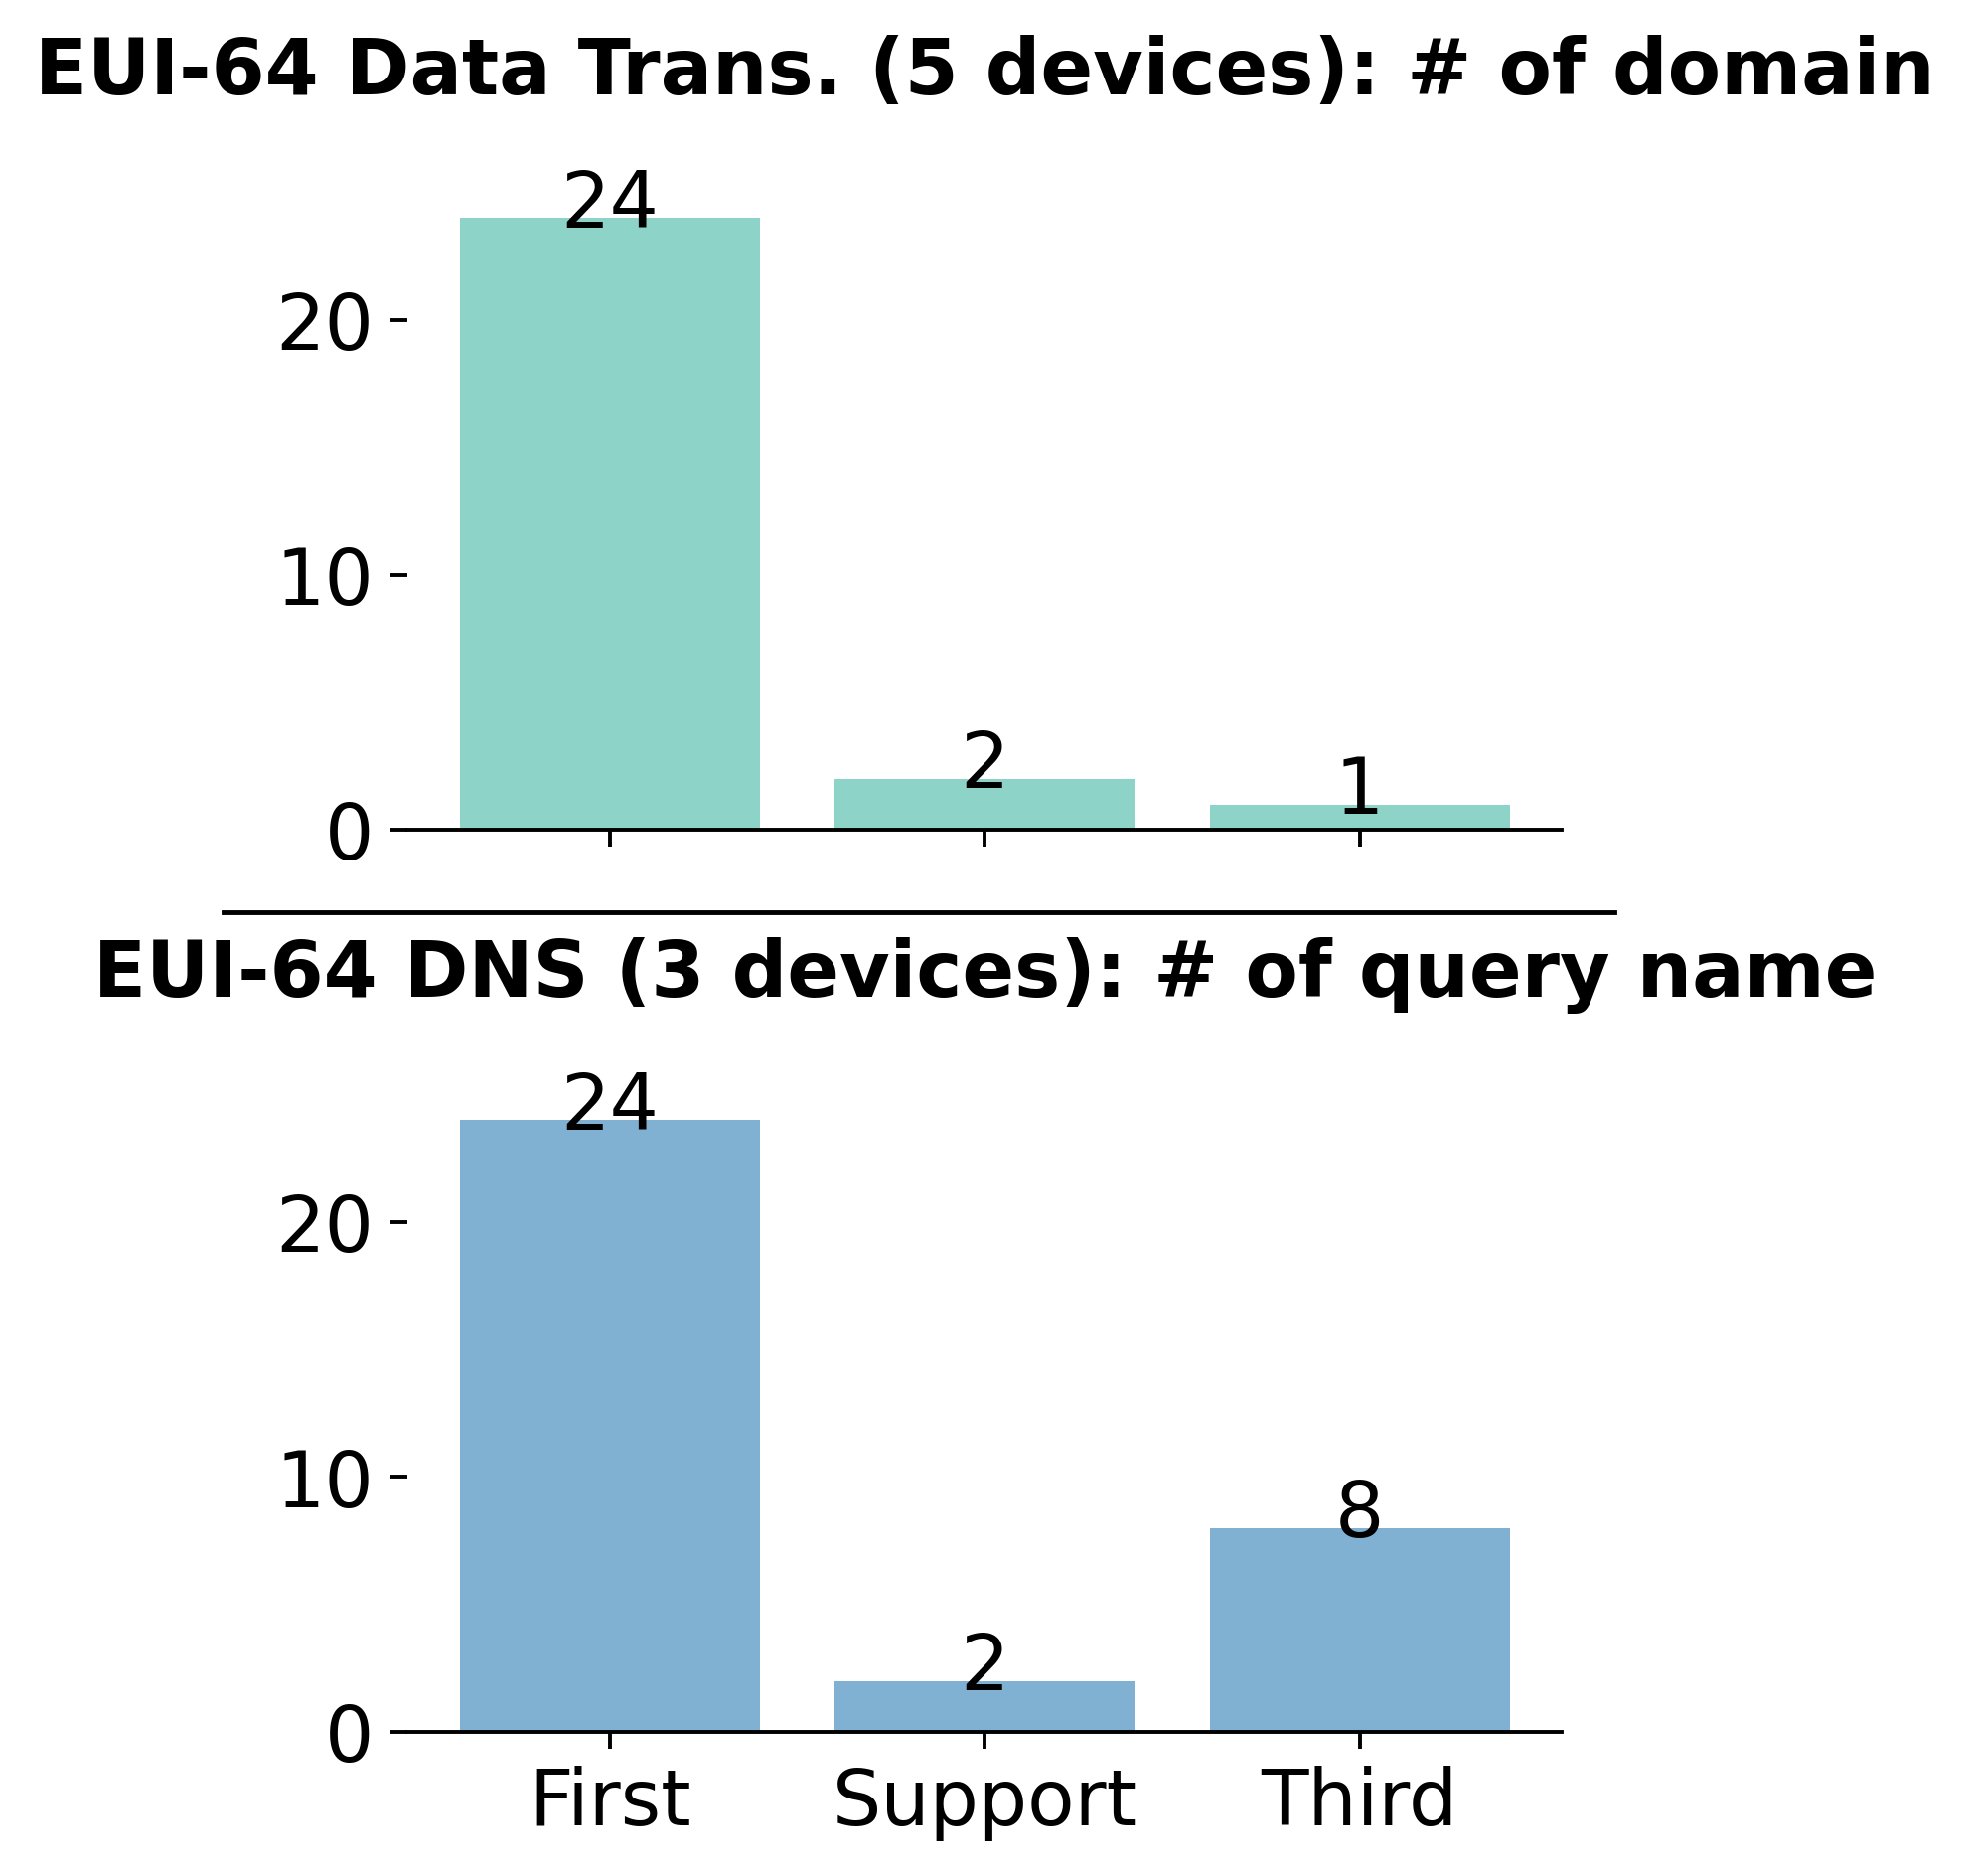

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as patches
import matplotlib.cm as cm
import os
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
input_path = 'destination_party'
input_file = 'destination_may8_global_eui64_destination.csv'
output_path = 'plotting'
if not os.path.exists(output_path):
    os.makedirs(output_path)
data = pd.read_csv(os.path.join(input_path, input_file))
party = data['party']
counts = party.value_counts().to_dict()
values = list(counts.values())
labels = ['First',  'Support', 'Third']

title_fontsize = 16
tick_fontsize = 16
label_fontsize = 14

fig, axs = plt.subplots(2, 1, figsize=(4, 6), dpi=350)

# First subplot
axs[0].bar(labels, values, color=(0.5529411764705883, 0.8274509803921568, 0.7803921568627451, 1.0))
for i in range(len(labels)):
    axs[0].text(i, values[i]+0.5, f'{values[i]}', ha='center', va='center', fontsize=tick_fontsize)
axs[0].spines["right"].set_visible(False)
axs[0].spines["left"].set_visible(False)
axs[0].spines["top"].set_visible(False)
# axs[0].set_ylabel("Number of Domain", fontsize=label_fontsize) 
# axs[0].xaxis.get_label().set_style('italic')
axs[0].set_xticklabels([])
axs[0].yaxis.get_label().set_style('italic')
axs[0].set_title('EUI-64 Data Trans. (5 devices): # of domain', fontsize=title_fontsize, y=1.1, fontweight='bold')
axs[0].tick_params(axis='x', labelsize=tick_fontsize)
axs[0].tick_params(axis='y', labelsize=tick_fontsize)

# Second subplot
values = [24, 2, 8]
axs[1].bar(labels, values, color=(0.5019607843137255, 0.6941176470588235, 0.8274509803921568, 1.0))
for i in range(len(labels)):
    axs[1].text(i, values[i]+0.5, f'{values[i]}', ha='center', va='center', fontsize=tick_fontsize)
axs[1].spines["right"].set_visible(False)
axs[1].spines["left"].set_visible(False)
axs[1].spines["top"].set_visible(False)
# axs[1].set_ylabel("Number of Query Name", fontsize=label_fontsize) 
axs[1].xaxis.get_label().set_style('italic')
axs[1].yaxis.get_label().set_style('italic')
axs[1].set_title('EUI-64 DNS (3 devices): # of query name', fontsize=title_fontsize, y=1.1, fontweight='bold')
# fig.suptitle("", fontsize=title_fontsize, x=0.5, y=0.85, fontweight='bold')
axs[1].tick_params(axis='x', labelsize=tick_fontsize)
axs[1].tick_params(axis='y', labelsize=tick_fontsize)
# Add a horizontal line between the subplots
line = plt.Line2D([0, 1], [0.5, 0.5], transform=fig.transFigure, color="black", linewidth=1)
fig.add_artist(line)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
